# Рябыкин Алексей

## **RuCode Festival 6.0**

Main idea: Transfer Learning

In [1]:
from tqdm import tqdm_notebook
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Nov 25 21:23:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8     3W /  N/A |    275MiB /  4096MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [5]:
from torchvision.transforms.transforms import Resize
class CarsDataset(Dataset):
    """
    Images dataset which loads them from the directories and make their scaling
    and converting to tensors.
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.transform = transform if transform != None else transforms.Compose([
              transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('train/')
TEST_DIR = Path('public_test/')
PRIVATE_TEST_DIR = Path('private_dataset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
private_test_files = sorted(list(PRIVATE_TEST_DIR.rglob("*.jpg")))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = CarsDataset(val_files, mode='val')

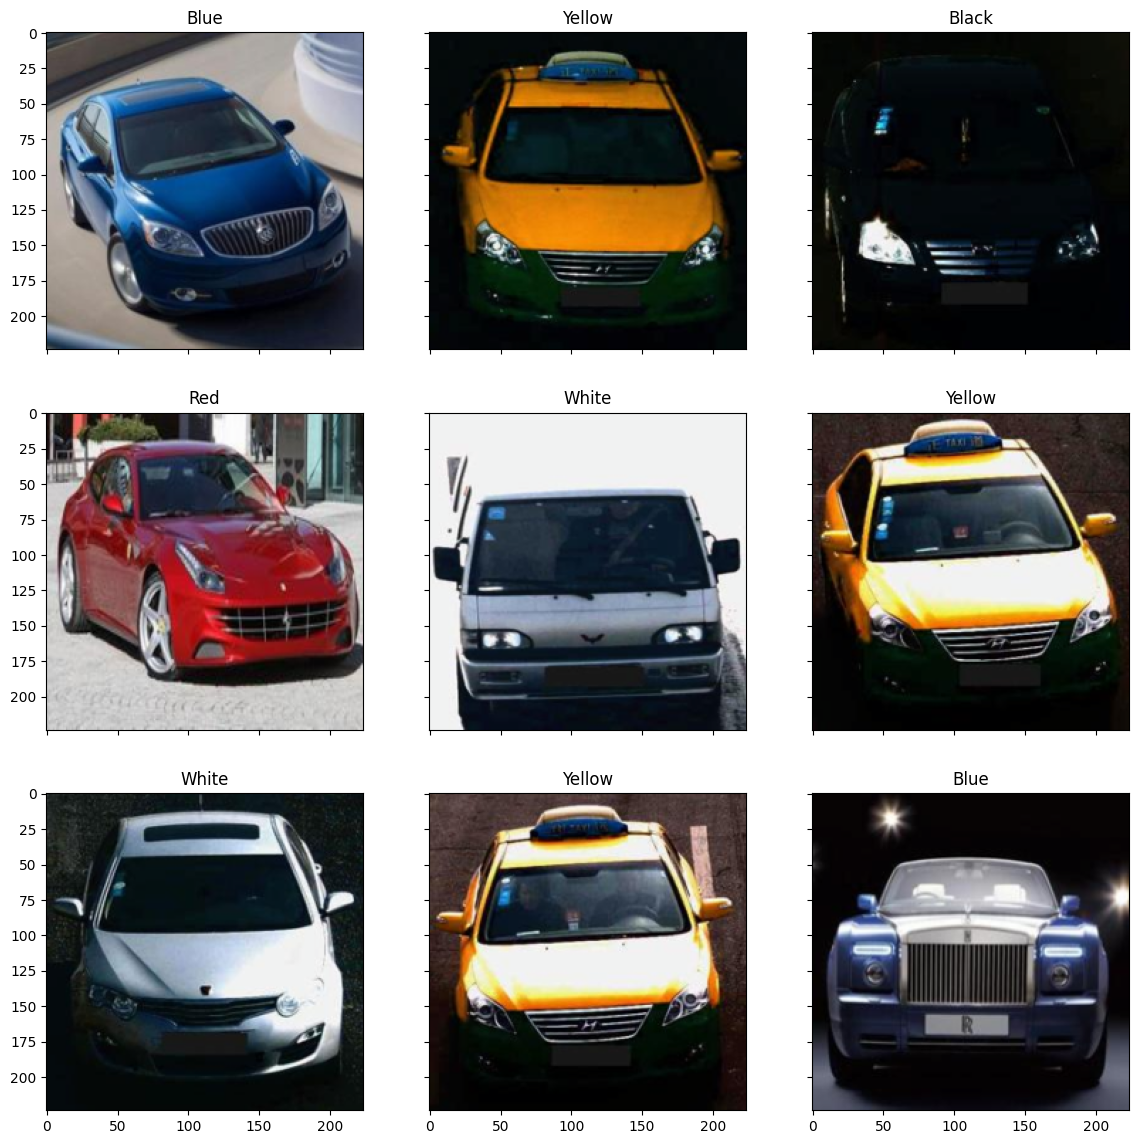

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(14, 14), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [11]:
transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=45),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=0.1, saturation=0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])

In [13]:
augmented = CarsDataset(train_files, 'train', transform=transform) 

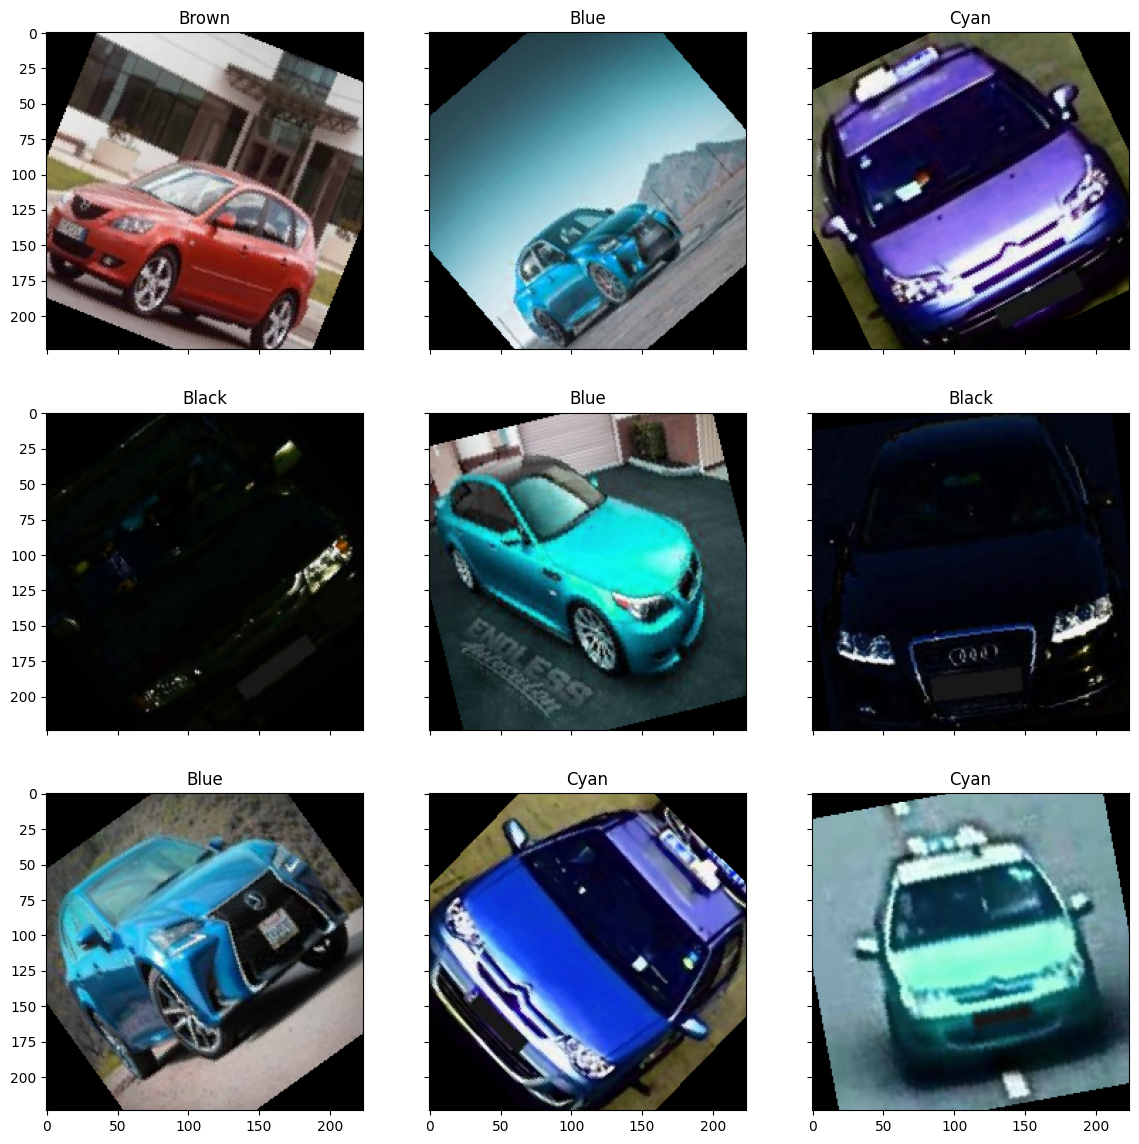

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(14, 14), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = augmented[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                augmented.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :11


Запустим обучение сети.

In [21]:
if val_dataset is None:
    val_dataset = CarsDataset(val_files, mode='val')
    
train_dataset = CarsDataset(train_files, mode='train')

In [22]:
def plot_history(history: list):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
    loss, acc, val_loss, val_acc = zip(*history)    
    try:
        val_acc = [i.cpu().numpy() for i in val_acc]
    except ValueError:
        print('Something went wrong')
    ax[0].plot(loss, label='train_loss')
    ax[0].plot(val_loss, label='val_loss')
    ax[1].plot(acc, label='train_acc')
    ax[1].plot(val_acc, label='val_acc')
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
 
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("acc")
    plt.show()

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [24]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [26]:
from sklearn.metrics import f1_score
def f1_scoring(model, count=50):
    idxs = list(map(int, np.random.uniform(0,950, count)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]
    return f1_score(actual_labels, preds_class, average='micro')

In [29]:
private_test_dataset = CarsDataset(private_test_files, mode="test")
private_test_loader = DataLoader(private_test_dataset, shuffle=False, batch_size=64)

private_test_filenames = [path.name for path in private_test_dataset.files]


In [30]:
test_dataset = CarsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
# probs = predict(simple_cnn, test_loader)


# preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [31]:
import pandas as pd

In [32]:
def to_submit(test_files: list, test_dataset: CarsDataset, model, save=False) -> pd.DataFrame:
  test_dataset = CarsDataset(test_files, mode="test")
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
  probs = predict(model, test_loader)


  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]
  result = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
  if save:
    result.to_csv('submission.csv', index=False)
  return result

## FineTuning ResNet101, Inception

In [34]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def fit_epoch(model, tepoch, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tepoch:
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      preds = torch.argmax(outputs, 1)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      processed_data += inputs.size(0)
      tepoch.set_postfix(loss=loss.item(),
       accuracy=100. * running_corrects.cpu().numpy() / processed_data)

              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def train(train_files, val_files,
           model, epochs, batch_size, 
           optimizer=None, criterion=None, scheduler=None):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}\n"
    optimizer = torch.optim.Adam(model.parameters()) if optimizer == None else optimizer
    criterion = nn.CrossEntropyLoss() if criterion == None else criterion

    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            train_loss, train_acc = fit_epoch(model, tepoch, criterion, optimizer)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if scheduler != None:
              scheduler.step()
            tepoch.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return history

In [35]:
import torchvision
from torch.optim import lr_scheduler

In [36]:
model101 = torchvision.models.resnet101(pretrained=True).to(DEVICE)
model101.fc

c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aleksey Ryabykin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=1000, bias=True)

In [37]:
for num, child in enumerate(model101.children()):
    if num < 6:
        for param in child.parameters():
            param.requires_grad = False


model101.fc = nn.Linear(2048, n_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    list(model101.layer3.parameters())+list(model101.layer4.parameters()),
    lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [38]:
history = train(train_files=train_dataset, val_files=val_dataset,
        model=model101, epochs=10, batch_size=32, optimizer=optimizer,
        scheduler=scheduler, criterion=criterion)

Epoch 1: 100%|██████████| 90/90 [01:48<00:00,  1.20s/batch, accuracy=87.7, loss=1.6]   



Epoch 001 train_loss: 0.4667     val_loss 0.1517 train_acc 0.8772 val_acc 0.9506



Epoch 2: 100%|██████████| 90/90 [01:24<00:00,  1.07batch/s, accuracy=91.6, loss=0.0139]



Epoch 002 train_loss: 0.2949     val_loss 0.2020 train_acc 0.9162 val_acc 0.9422



Epoch 3: 100%|██████████| 90/90 [01:23<00:00,  1.08batch/s, accuracy=95.9, loss=0.0322] 



Epoch 003 train_loss: 0.1650     val_loss 0.2394 train_acc 0.9590 val_acc 0.9338



Epoch 4: 100%|██████████| 90/90 [38:31<00:00, 25.69s/batch, accuracy=98.6, loss=0.001]     



Epoch 004 train_loss: 0.0423     val_loss 0.0693 train_acc 0.9863 val_acc 0.9758



Epoch 5: 100%|██████████| 90/90 [00:58<00:00,  1.54batch/s, accuracy=99.4, loss=0.00622] 



Epoch 005 train_loss: 0.0156     val_loss 0.0625 train_acc 0.9940 val_acc 0.9811



Epoch 6: 100%|██████████| 90/90 [00:58<00:00,  1.54batch/s, accuracy=99.8, loss=0.00573] 



Epoch 006 train_loss: 0.0086     val_loss 0.0624 train_acc 0.9975 val_acc 0.9811



Epoch 7: 100%|██████████| 90/90 [00:58<00:00,  1.54batch/s, accuracy=99.9, loss=2.17e-5] 



Epoch 007 train_loss: 0.0057     val_loss 0.0606 train_acc 0.9986 val_acc 0.9832



Epoch 8: 100%|██████████| 90/90 [00:58<00:00,  1.54batch/s, accuracy=99.9, loss=2.09e-5] 



Epoch 008 train_loss: 0.0048     val_loss 0.0601 train_acc 0.9989 val_acc 0.9832



Epoch 9: 100%|██████████| 90/90 [01:04<00:00,  1.40batch/s, accuracy=99.9, loss=4.68e-5] 



Epoch 009 train_loss: 0.0042     val_loss 0.0596 train_acc 0.9993 val_acc 0.9821



Epoch 10: 100%|██████████| 90/90 [01:05<00:00,  1.37batch/s, accuracy=99.9, loss=0.000218]



Epoch 010 train_loss: 0.0039     val_loss 0.0596 train_acc 0.9993 val_acc 0.9821



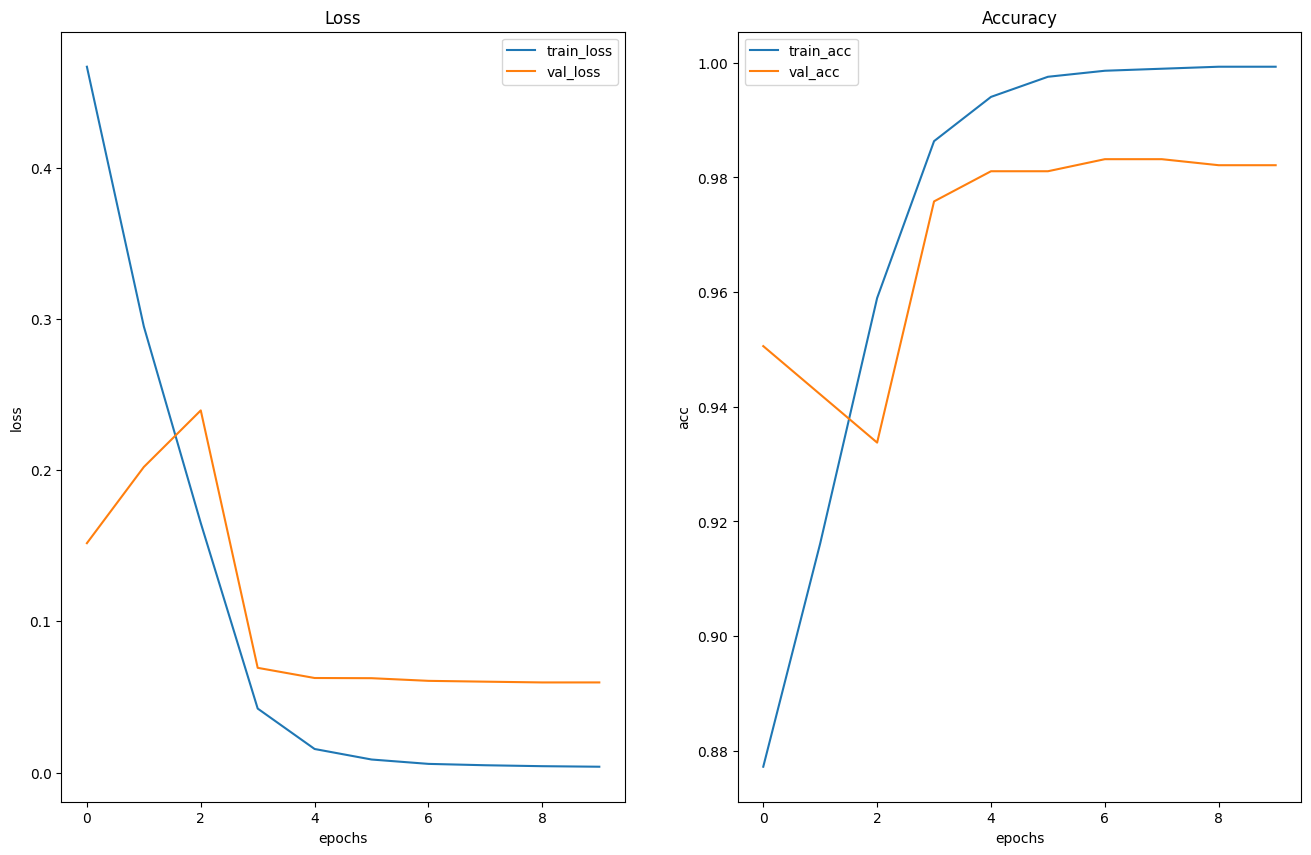

In [39]:
plot_history(history)

In [56]:
history += train(train_files=augmented, val_files=val_dataset,
         model=model101, epochs=1, batch_size=64,
         optimizer=optimizer, criterion=criterion)

Epoch 1: 100%|██████████| 246/246 [09:49<00:00,  2.40s/batch, accuracy=87.1, loss=0.687]



Epoch 001 train_loss: 0.5586     val_loss 0.1432 train_acc 0.8706 val_acc 0.9727



In [60]:
history = train(train_files=val_dataset, val_files=val_dataset,
        model=model101, epochs=1, batch_size=64, optimizer=optimizer,
        scheduler=scheduler, criterion=criterion)

Epoch 1: 100%|██████████| 82/82 [02:51<00:00,  2.09s/batch, accuracy=97.4, loss=0.0114]



Epoch 001 train_loss: 0.1383     val_loss 0.1356 train_acc 0.9740 val_acc 0.9744



In [40]:
f1_scoring(model101, count=5)

1.0

In [ ]:
plot_history(history)

In [86]:
res = to_submit(test_files=private_test_files, test_dataset=private_test_dataset, model=model101, save=True)

In [67]:
res['numeric_id'] = res['Id'].apply(lambda row: int(row.split('.')[0]))

In [71]:
sorted_res = res.sort_values("numeric_id")

In [74]:
sorted_res.drop(columns=["Id", "numeric_id"]).to_csv("submission1.csv", header=False, index=False)